# **2. Illustrative Example: Predicting Risk of Ischemic Stroke**


In [1]:
import pandas as pd
import pyreadr
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from itertools import combinations

# sklearn and scipy imports
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.dummy import DummyClassifier
from scipy.stats import ttest_ind, pearsonr, chi2, chi2_contingency

# preprocessing imports
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  RocCurveDisplay

# visualization, display and printing
from matplotlib.pyplot import figure
from IPython.display import display, Math

# ggplot layers
from plotnine import (ggplot, aes, geom_point, geom_bar, geom_density, scale_fill_manual, theme, theme_minimal,
                      scale_color_manual, geom_boxplot, geom_histogram, ggtitle, facet_wrap, xlab, ylab, geom_text)

# for setting plot size mainly
import plotnine.options as ggplot_options

%matplotlib inline

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


In [2]:
stroke_data = pyreadr.read_r("./data/Ischemic_Stroke/stroke_data.RData")

# train and test sets
stroke_train_df = stroke_data['stroke_train']
stroke_test_df = stroke_data['stroke_test']

# response
y_train = stroke_train_df['Stroke']

# VascuCap software generated predictors
VC_PREDICTORS = [
  'CALCVol', 'CALCVolProp', 'MATXVol', 'MATXVolProp', 'LRNCVol', 
  'LRNCVolProp', 'MaxCALCArea', 'MaxCALCAreaProp', 'MaxDilationByArea', 
  'MaxMATXArea', 'MaxMATXAreaProp', 'MaxLRNCArea', 'MaxLRNCAreaProp', 
  'MaxMaxWallThickness', 'MaxRemodelingRatio', 'MaxStenosisByArea', 
  'MaxWallArea', 'WallVol', 'MaxStenosisByDiameter'
]

# those predictors are probably surveyed
RISK_PREDICTORS = [
  'age', 'sex', 'SmokingHistory', 'AtrialFibrillation', 'CoronaryArteryDisease', 
  'DiabetesHistory', 'HypercholesterolemiaHistory', 'HypertensionHistory'
]

stroke_train_df['Stroke'].value_counts(normalize=True)

Y    0.505618
N    0.494382
Name: Stroke, dtype: float64

We see that we have no class imbalance.

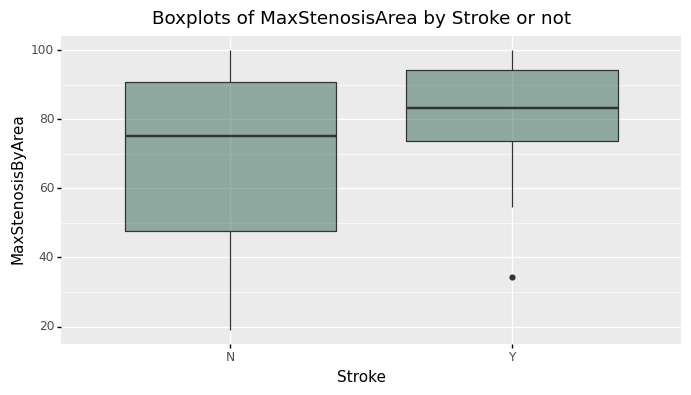

<ggplot: (313099240)>

In [3]:
ggplot_options.figure_size = (8, 4)

(ggplot(stroke_train_df) +
    aes(x='Stroke', y='MaxStenosisByArea') +
    geom_boxplot(fill='#336655', alpha=0.5) +
    ggtitle("Boxplots of MaxStenosisArea by Stroke or not")
)

The distribution of max stenosis by area seems to be a lot higher when there is in fact a stroke.

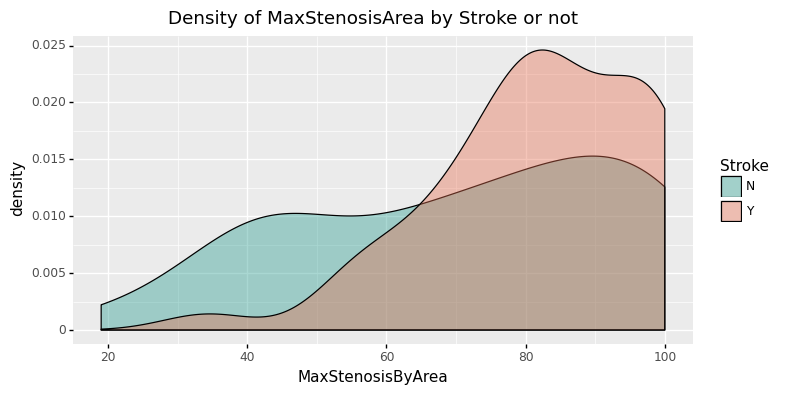

<ggplot: (313215708)>

In [4]:
(ggplot(stroke_train_df) +
    aes(x='MaxStenosisByArea', fill='Stroke') +
    geom_density(alpha=0.4) +
    ggtitle("Density of MaxStenosisArea by Stroke or not") +
    scale_fill_manual(values=["#2a9d8f", "#e76f51"])
)

#### Testing whether the distributions for <u>max_stenosis_by_area</u> for stroke and no stroke are the same

In [5]:
has_stroke = stroke_train_df['Stroke'] == 'Y'
max_stenosis_by_area = stroke_train_df['MaxStenosisByArea']

max_sten_pvalue = ttest_ind(
    max_stenosis_by_area[has_stroke],
    max_stenosis_by_area[~has_stroke],
    equal_var=False,
    alternative='greater'
).pvalue

corr, _ = pearsonr(stroke_train_df['MaxStenosisByArea'], stroke_train_df['MaxStenosisByDiameter'])

print("The correlation between MaxStenosisByArea and MaxStenosisByDiameter is {:.2f}".format(corr))

print("-------------------------------------------------------------------------------------------")

print(
    """There's a statistically significant difference between the distributions of MaxStenosisByDiameter,
      with a pvalue={:.2f}""".format(max_sten_pvalue)
)


The correlation between MaxStenosisByArea and MaxStenosisByDiameter is 0.94
-------------------------------------------------------------------------------------------
There's a statistically significant difference between the distributions of MaxStenosisByDiameter,
      with a pvalue=0.01


There's high correlation between <u>MaxStenosisByArea</u> and <u>MaxStenosisByDiameter</u> which is to be expected since area is a function of diameter.
Maybe for modelling only one of the predictors might be useful.

### **Description on some of the variables**

* CALCVol - calcified plaque volume
* LRNCVol - Lipid Rich Necrotic Core plaque volume
* MaxCALCArea - area of CALC
* MaxLRNCArea - area of LRNC
* MaxStenosisByDiameter
* MaxRemodelingRatio - Remodeling ratio is a measure of the arterial wall where ratios less than 1 indicate a wall shrinkage and ratios greater than 1 indicate wall growth. This metric is likely important because coronary arteries with large ratios like the one displayed here have been associated with rupture (Cilla et al. 2013; Abdeldayem et al. 2015). 


|       | Stroke = No | Stroke = Yes     |
| :---        |    :----:   |          ---: |
| Blockage < 70%      | 43       | 39   |
| Blockage > 70%   | 19        | 25      |

Let's use the $\chi^2$ test for independence, first by hand.

In [6]:
observed = np.array([[43, 39], [19, 25]])
n = observed.sum()

x_marginal = observed.sum(axis=1) / n
y_marginal = observed.sum(axis=0) / n

expected = n * np.matmul(x_marginal.reshape(-1, 1), y_marginal.reshape(1, -1))

# using yates correction
chsq_stat = ((np.abs((observed - expected)) - 0.5) ** 2 / expected).sum()
pval = (1 - chi2.cdf(chsq_stat, df=1))

print("Chisq-test for indpendence with pvalue={:.2f}".format(pval))

Chisq-test for indpendence with pvalue=0.42


Or simply by using the chisq independence test

In [7]:
# or simply by using the chisq test for independence
_, pval, *_ = chi2_contingency(observed)
print("pvalue={:.2f}".format(pval))

pvalue=0.42


We can see that we cannot reject independence between Stroke and Blockage above 70%, even though that has been the historical requirement for surgical intervention.

The association between blockage categorization and stroke outcome is provided in Table 2.1. For these patients, the association is not statistically significant based on a chi-squared test of association (p = 0.42), indicating that blockage categorization alone is likely not a good predictor of stroke outcome.

<br /><br />

## **2.2 Preprocessing**

One of the first steps of the modeling process is to understand important predictor characteristics such as their individual distributions, the degree of missingness within each predictor, potentially unusual values within predictors, relationships between predictors, and the relationship between each predictor and the response and so on.

#### **Explore missing data**

In [8]:
(stroke_train_df[['Stroke']]
 .assign(data='train')
 .append(stroke_test_df[['Stroke']].assign(data='test'))
 .groupby(['data', 'Stroke'])
 .size()
 .reset_index()
 .pivot_table(index='data', columns='Stroke')
 .set_axis(['No', 'Yes'], axis=1)
)

,No,Yes
data,,
test,18,19
train,44,45


### **Individual Distributions of Predictors**

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


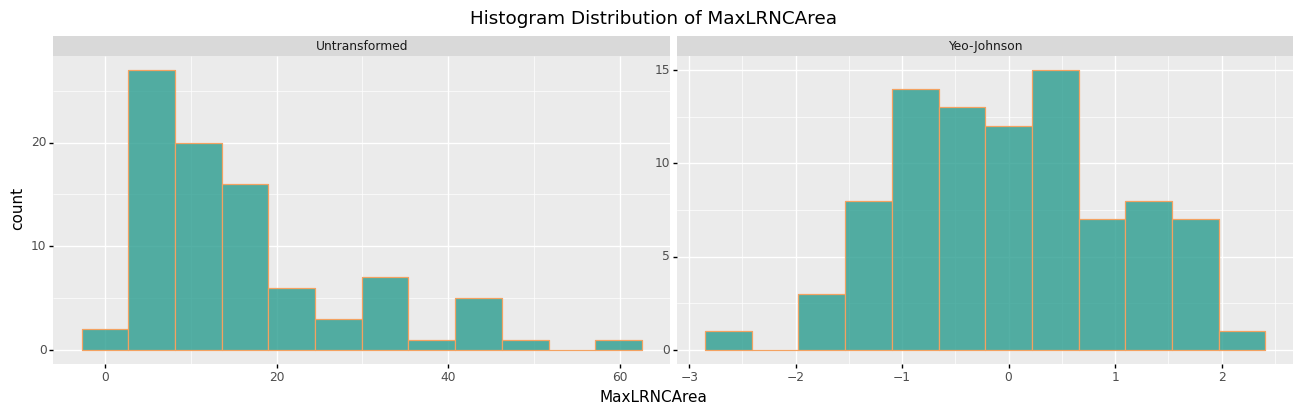

<ggplot: (313212043)>

In [9]:
ggplot_options.figure_size = (16, 4)

power_transformer = PowerTransformer(method='yeo-johnson')

transformed_arr = power_transformer.fit_transform(stroke_train_df[['MaxLRNCArea']])
transformed_df = pd.DataFrame(transformed_arr, columns=['MaxLRNCArea'])

(stroke_train_df[['MaxLRNCArea']]
 .assign(type='Untransformed')
 .append(transformed_df[['MaxLRNCArea']].assign(type='Yeo-Johnson'))
 .pipe(ggplot) +
    aes(x='MaxLRNCArea', fill='type') +
    geom_histogram(fill='#2a9d8f', color='#f4a261', alpha=0.8, bins=12) +
    ggtitle("Histogram Distribution of MaxLRNCArea") +
    facet_wrap('type', scales='free')
)

This kind of transformation makes sense for measurements that increase exponentially. Here, the lipid area naturally grows multiplicatively by definition of how areas is calculated.

LRNC = Lipid Rich Necrotic Core

MaxLRNCArea is a measurement of the mixture of lipid pools and necrotic cellular debris for a cross-section of the stenosis.


there are three pairs of predictors that show unacceptably high correlations:

* vessel wall volume in $mm^3$
* (WallVol) and matrix volume (MATXVol), maximum cross-sectional wall area in  $mm^2$
* (MaxWallArea) and maximum matrix area (MaxMATXArea)
* maximum cross-sectional stenosis based on area (MaxStenosisByArea) and maximum cross-sectional stenosis based on diameter (MaxStenosisByDiameter)

Text(0.5, 1.0, 'Correlation Heatmap')

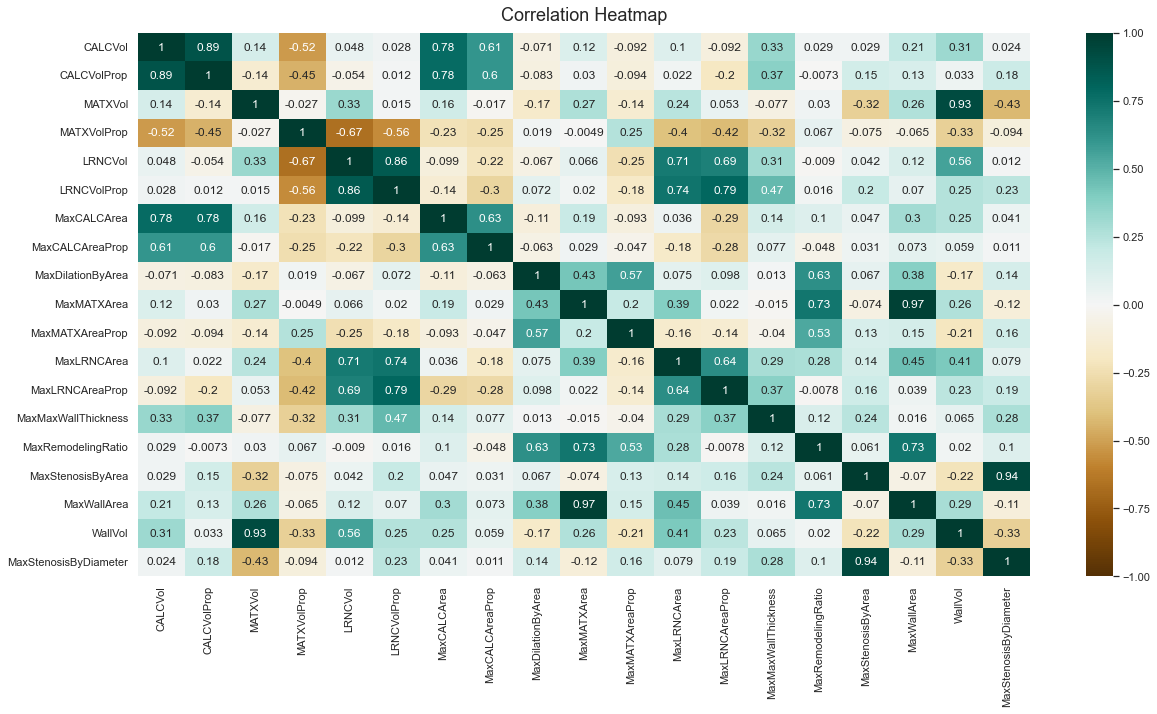

In [10]:
sns.set(rc={'figure.figsize': (20, 10)})

heatmap = sns.heatmap(stroke_train_df[VC_PREDICTORS].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=12)

We establish the following correlations:

* cor(MATXVol, WallVol) = 0.93
* cor(CALCVol, CALCVolProp) = 0.89
* cor(MaxStenosisByArea, MaxStenosisByDiameter) = 0.94
* cor(MaxMatxArea, MaxWallArea) = 0.97


Next, we will remove predictors that are highly correlated ( r > 0.9) with other predictors. The correlation among the imaging predictors can be visually seen in the heatmap in Figure 2.3 where the order of the columns and rows are determined by a clustering algorithm. Here, there are three pairs of predictors that show unacceptably high correlations:

* vessel wall volume in  mm3 (WallVol) and matrix volume (MATXVol),
* maximum cross-sectional wall area in  mm2 (MaxWallArea) and maximum matrix area (MaxMATXArea)
* maximum cross-sectional stenosis based on area (MaxStenosisByArea) and maximum cross-sectional stenosis based on diameter (MaxStenosisByDiameter).


<br/>

## **2.3 Exploration**
The next step is to explore potential predictive relationships between individual predictors and the response and between pairs of predictors and the response.

when we want to compare two models ($M_1$ and $M_2$), the following procedure, discussed more in Section 3.7, will be used:

![Tux, the Linux mascot](./images/algo-model-compare.png)

The Repated cross-validation makes a 10-fold cross validation 5 times.

In [11]:
RANDOM_STATE = 2

dummy_clf = DummyClassifier(random_state=RANDOM_STATE, strategy='most_frequent')
lr_clf = LogisticRegression(fit_intercept=True, penalty='none')

def get_model_improve(df, model, response, random_state=1):
    dummy = DummyClassifier(random_state=random_state, strategy='most_frequent')
    rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=random_state)

    # scores of the model and the dummy model
    m1_scores = cross_val_score(model, df, response, cv=rkf, scoring='roc_auc')
    m2_scores = cross_val_score(dummy, df, response, cv=rkf, scoring='roc_auc')

    # get mean roc score for the improved model, mean improvement and the pvalue
    roc = m1_scores.mean()
    improvement = (m1_scores - m2_scores).mean()
    pval = ttest_ind(m1_scores, m2_scores, alternative='greater').pvalue

    return df.columns[0], roc, improvement, pval

In [12]:
ALL_PREDS = VC_PREDICTORS + RISK_PREDICTORS
# get improvement metrics for all of the different variables
CMP_RESULT_COLS = ['variable', 'roc', 'improvement', 'pvalue']

results = [get_model_improve(stroke_train_df[[feat]], lr_clf, stroke_train_df['Stroke']) for feat in ALL_PREDS]

results_df = pd.DataFrame(results, columns=CMP_RESULT_COLS).sort_values(by='improvement', ascending=False)
results_df.head(3)


,variable,roc,improvement,pvalue
13,MaxMaxWallThickness,0.728401,0.228401,2.653304e-12
14,MaxRemodelingRatio,0.670770,0.170770,7.869521e-11
18,MaxStenosisByDiameter,0.632548,0.132548,1.881134e-05


Boxplots with the different numeric predictors.

In [13]:
ggplot_options.figure_size = (12, 8)

pt = PowerTransformer(method='yeo-johnson')
vc_stroke_train_df = stroke_train_df[VC_PREDICTORS]

vc_stroke_train_scaled_df = pd.DataFrame(
    pt.fit_transform(vc_stroke_train_df),
    columns=vc_stroke_train_df.columns
)

# reproduce the boxplots from the book
boxplots_plt = (vc_stroke_train_scaled_df
 .assign(Stroke=stroke_train_df['Stroke'])
 .melt(id_vars='Stroke')
 .pipe(ggplot) +
    # TODO: it misses pvalues like in the book
    aes(x='Stroke', y='value') +
    geom_boxplot(fill='#336622', alpha=0.4) +
    facet_wrap('variable')
)

# show by uncommenting next line
# boxplots_plt

At this point best features seem to be MaxMaxWallThickness and MaxRemodelingRatio. Let's see how a ROC curve would look for the MaxRemodelingRatio.

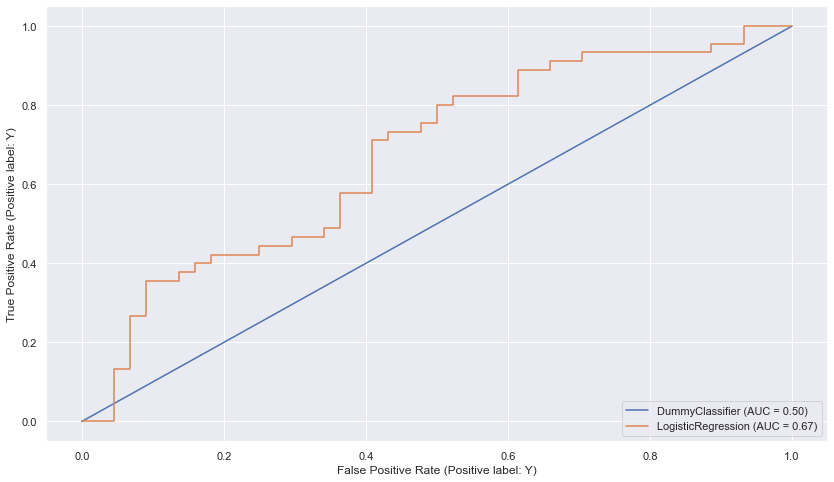

In [14]:
# change the plot size
sns.set(rc={'figure.figsize':(14, 8)})

# create logistic regression and a dummy model
lr = LogisticRegression(penalty='none')
dc = DummyClassifier(strategy='most_frequent')

# fit them
lr.fit(vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke'])
dc.fit(vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke'])

# plot the base line dummy model
ax = RocCurveDisplay.from_estimator(dc, vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke']).ax_

# plot the improved MaxRemodelingRatio model
RocCurveDisplay.from_estimator(lr, vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke'], ax=ax)

## **Exploring Interactions**

In [ ]:
def interactize_frame(df, poly_tr):
    """returns a dataframe using a poly transformer so that intercations are obtained"""
    transformed_arr = poly_tr.fit_transform(df)
    columns = poly_tr.get_feature_names_out(df.columns)
    return pd.DataFrame(transformed_arr, columns=columns)

def compare_models(df1, df2, response, rkf):
    """compare two models, one on two of the predictors, and another with the interaction"""
    model1 = LogisticRegression(penalty='none')
    model2 = LogisticRegression(penalty='none')

    # scores of the model and the dummy model
    m1_scores = cross_val_score(model1, df1, response, cv=rkf, scoring='roc_auc')
    m2_scores = cross_val_score(model2, df2, response, cv=rkf, scoring='roc_auc')

    # get mean roc score for the improved model, mean improvement and the pvalue from a t.test
    roc = m1_scores.mean()
    improvement = (m1_scores - m2_scores).mean()
    pval = ttest_ind(m1_scores, m2_scores, alternative='greater').pvalue

    return df2.columns[2], roc, improvement, pval

# generate all kind of combinations of the features
feature_combinations = np.asarray(list(combinations(VC_PREDICTORS, 2)))
rkf = RepeatedKFold(n_splits=10, n_repeats=5)
poly_transformer = PolynomialFeatures(interaction_only=True, include_bias = False)

# dataframes of all combinations 
combo_frames = [vc_stroke_train_scaled_df[combo] for combo in feature_combinations]
# dataframes of combinations and added interactions
interact_frames = [interactize_frame(df, poly_transformer) for df in combo_frames]

int_results_arr = [compare_models(cdf, idf, y_train, rkf) for cdf, idf in zip(combo_frames, interact_frames)]
int_results_df = pd.DataFrame(int_results_arr, columns=CMP_RESULT_COLS)

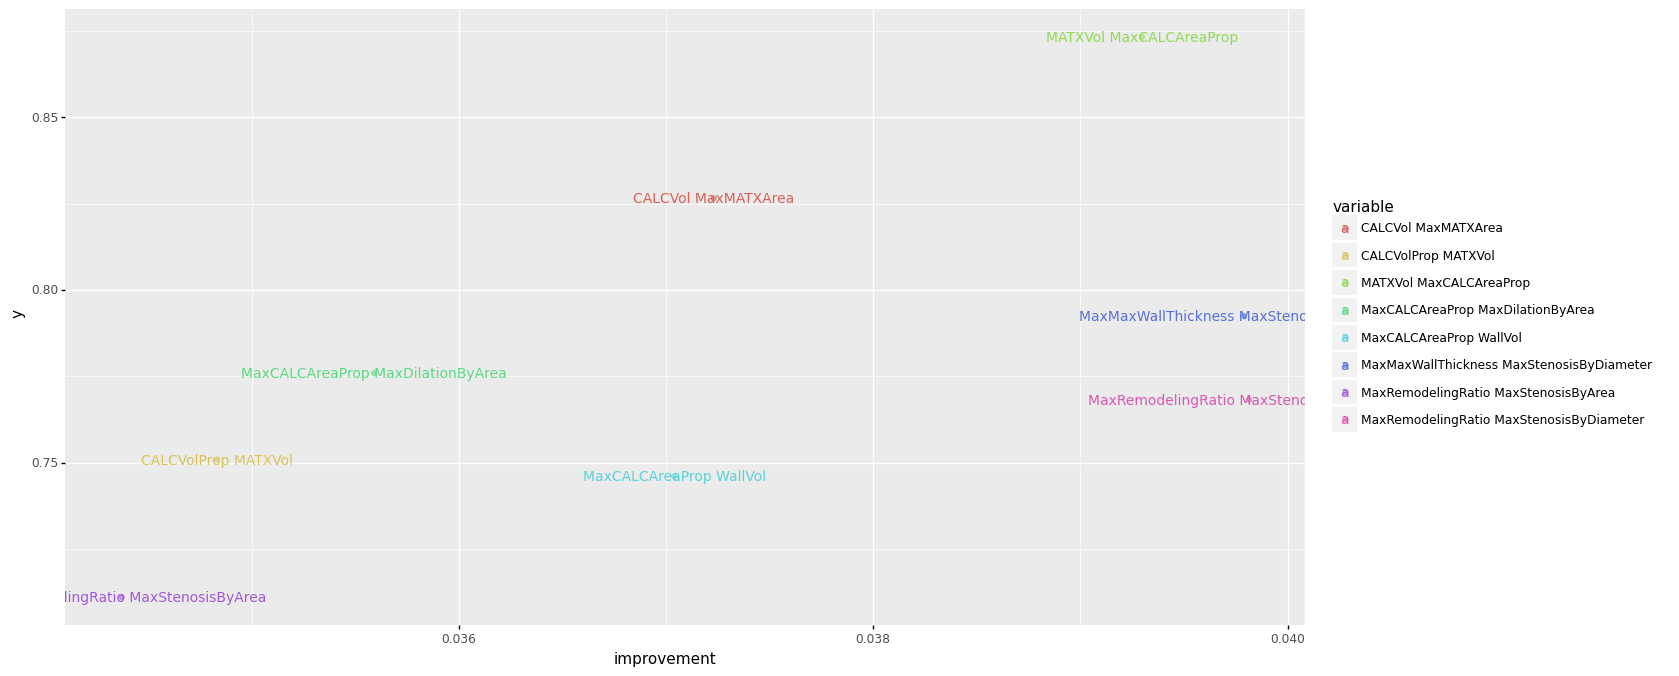

<ggplot: (313148022)>

In [16]:
ggplot_options.figure_size = (16, 8)

(int_results_df[(int_results_df['roc'] > 0.5) & (int_results_df['pvalue'] < 0.2)]
 .sort_values(by='improvement')
 .head(8)
 .assign(y=lambda x: -np.log10(x['pvalue']))
 .pipe(ggplot) +
    aes(x='improvement', y='y', color='variable') +
    geom_point(alpha=0.5) +
    geom_text(aes(label='variable'), size=10)
)

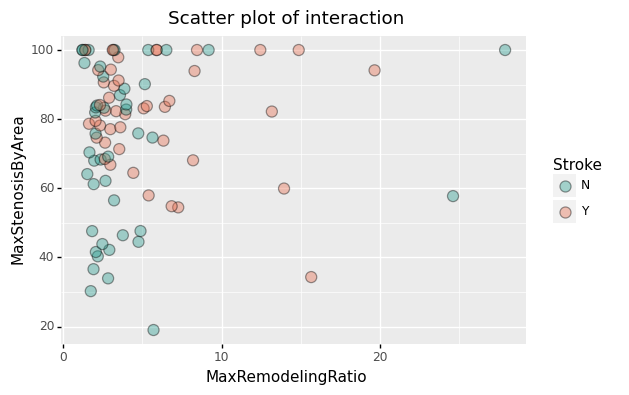

<ggplot: (313767226)>

In [17]:
ggplot_options.figure_size = (6, 4)

(ggplot(stroke_train_df) +
    aes(x='MaxRemodelingRatio', y='MaxStenosisByArea', fill='Stroke') +
    geom_point(size=4, alpha=0.4) +
    ggtitle("Scatter plot of interaction") +
    scale_fill_manual(values=["#2a9d8f", "#e76f51"])
)

Testing for whether there is significant difference of MaxRemodelingRatio * MaxStenosisByArea with a t.test
pvalue = 0.07


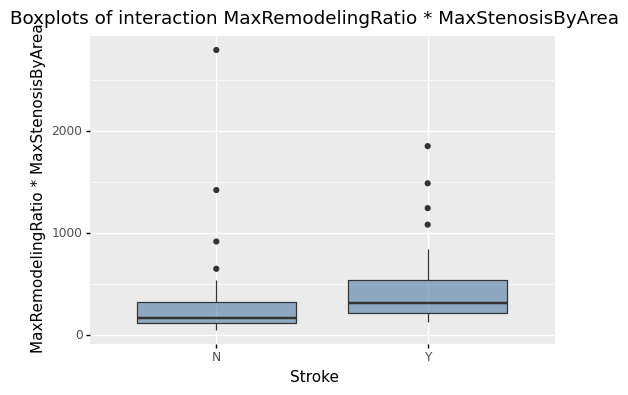

<ggplot: (313805020)>

In [18]:
interaction = stroke_train_df['MaxRemodelingRatio'] * stroke_train_df['MaxStenosisByArea']

pval = ttest_ind(interaction[y_train == 'Y'], interaction[y_train == 'N'], alternative='greater').pvalue

print("Testing for whether there is significant difference of MaxRemodelingRatio * MaxStenosisByArea with a t.test")
print("pvalue = {:.2f}".format(pval))

(stroke_train_df
 .assign(mrr_msba_int=interaction)
 .pipe(ggplot) +
    aes(x='Stroke', y='mrr_msba_int') +
    geom_boxplot(fill='#336699', alpha=0.5) +
    ylab("MaxRemodelingRatio * MaxStenosisByArea") +
    ggtitle("Boxplots of interaction MaxRemodelingRatio * MaxStenosisByArea")
)


## **2.4 Predictive Modeling Across Sets**

At this point there are at least five progressive combinations of predictor sets that could be explored for their predictive ability: original risk set alone, imaging predictors alone, risk and imaging predictors together, imaging predictors and interactions of imaging predictors, and risk, imaging predictors, and interactions of imaging predictors. We’ll consider modeling several of these sets of data in turn.

### **Recursive Feature Elimination + Correlation Filter**



In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(penalty='none')
rkf = RepeatedKFold(n_splits=10, n_repeats=5)

rfecv = RFECV(lr, cv=rkf, scoring="roc_auc")

rfecv.fit(vc_stroke_train_scaled_df, y_train)

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names


RFECV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=None),
      estimator=LogisticRegression(penalty='none'), scoring='roc_auc')

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


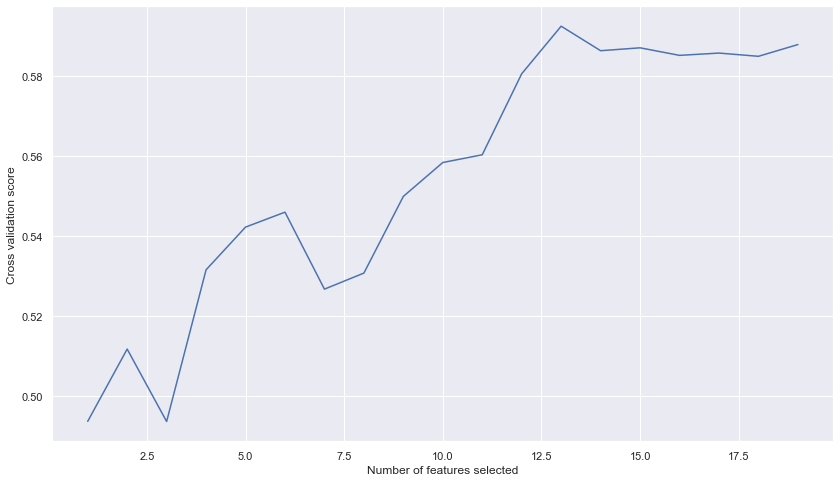

In [20]:
min_features_to_select = 1

rfecv.classes_

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")

rfecv.grid_scores_.shape[0]

plt.plot(range(min_features_to_select,
               rfecv.grid_scores_.shape[0] + min_features_to_select),
         rfecv.grid_scores_.mean(axis=1))
plt.show()


/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


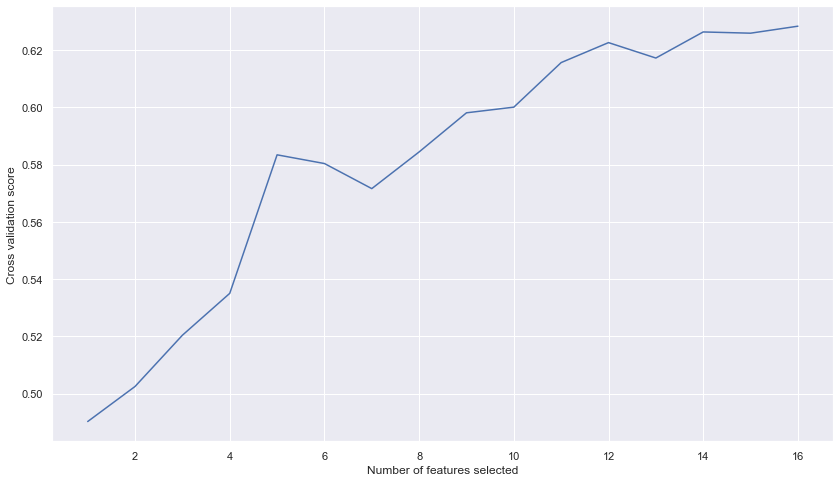

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilterTransformer(BaseEstimator, TransformerMixin):
    """Implementation of the correlation filter used in Feature Engineering and Selection"""
    def __init__(self, threshold=0.9):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        Xt = X.copy()
        if type(Xt).__module__ != np.__name__:
            Xt = Xt.to_numpy()

        corr_matrix = np.corrcoef(X.T).astype("float")
        corr_matrix[np.tril_indices(corr_matrix.shape[0])] = np.nan

        self._corr_indices = np.where(corr_matrix > self.threshold)
        return self

    def transform(self, X):
        return np.delete(X, self._corr_indices[1], axis=1)

    def get_removed_feature_names(self, columns):
        return columns[self._corr_indices[0]]

    def get_left_feature_names(self, columns):
        return np.delete(columns, self._corr_indices[0])

    def get_correlated_with(self, columns):
        return columns[self._corr_indices[1]]

    
crft = CorrelationFilterTransformer()

crft.fit(vc_stroke_train_scaled_df.to_numpy())
Xt = crft.transform(vc_stroke_train_scaled_df.to_numpy())

a = crft.get_removed_feature_names(vc_stroke_train_scaled_df.columns)
b = crft.get_correlated_with(vc_stroke_train_scaled_df.columns)
c = crft.get_left_feature_names(vc_stroke_train_scaled_df.columns)

df = pd.DataFrame(Xt, columns=c)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(penalty='none')
rkf = RepeatedKFold(n_splits=10, n_repeats=5)

rfecv = RFECV(lr, cv=rkf, scoring="roc_auc")

rfecv.fit(df, y_train)

min_features_to_select = 1

rfecv.classes_

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")

rfecv.grid_scores_.shape[0]

plt.plot(range(min_features_to_select,
               rfecv.grid_scores_.shape[0] + min_features_to_select),
         rfecv.grid_scores_.mean(axis=1))
plt.show()

In [22]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression

X_train = stroke_train_df

logistic_regression = LogisticRegression(penalty='none')
repeated_k_fold = RepeatedKFold(n_splits=5, n_repeats=5)

rec_feat_elim_cross_val = RFECV(logistic_regression, cv=repeated_k_fold, scoring="roc_auc")

vc_cols_pipe = Pipeline([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

pipeline = Pipeline([
    ('column_transformations', ColumnTransformer([("vc_cols_pipe", vc_cols_pipe, VC_PREDICTORS)])),
    ('zero_variance_filter', VarianceThreshold(0.1)),
    ('correlation_filter', CorrelationFilterTransformer()),
    ('rfecv', rec_feat_elim_cross_val)
])

pipeline.fit(X_train, y_train);

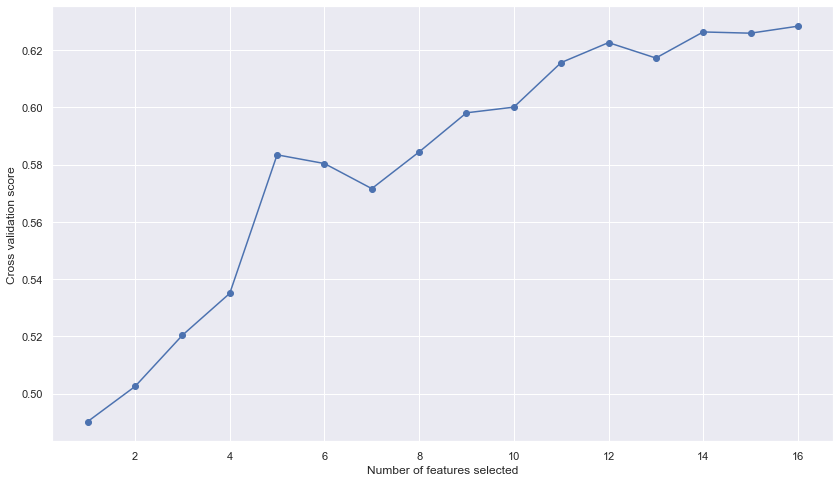

In [23]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")

mean_scores = rfecv.cv_results_['mean_test_score']
n_feat_to_select = range(min_features_to_select, mean_scores.shape[0] + 1)

plt.plot(n_feat_to_select, mean_scores, marker='o')
plt.show()

In [24]:
best_idx = rfecv.cv_results_['mean_test_score'].argmax()
rfecv.feature_names_in_[0:best_idx]

array(['CALCVol', 'CALCVolProp', 'MATXVolProp', 'LRNCVol', 'LRNCVolProp',
       'MaxCALCArea', 'MaxCALCAreaProp', 'MaxDilationByArea',
       'MaxMATXAreaProp', 'MaxLRNCArea', 'MaxLRNCAreaProp',
       'MaxMaxWallThickness', 'MaxRemodelingRatio', 'MaxWallArea',
       'WallVol'], dtype=object)

### **K-Best Feature Selection in a Pipeline**

In [25]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

kbest = SelectKBest(f_classif) 
rkf = RepeatedKFold(n_splits=5, n_repeats=5)

pipeline_k_best = Pipeline([
    # select particular columns
    ('column_transformations', ColumnTransformer([("vc_cols_pipe", vc_cols_pipe, VC_PREDICTORS)])),
    # remove zero variance predictors
    ('zero_variance_filter', VarianceThreshold(0.1)),
    # remove highly correlated clusters of variables
    ('correlation_filter', CorrelationFilterTransformer()),
    # select k-best predictors
    ('kbest', kbest),
    # apply the logistic regression
    ('lr', LogisticRegression(penalty='none'))
])

# in order to select the k-best features, we need to do that on a cross-validation grid search
# the whole process (pipeline) has to be repeated in order not to overfit
grid_search = GridSearchCV(pipeline_k_best, {'kbest__k': range(1, 14)}, scoring="roc_auc", cv=rkf)

grid_search.fit(X_train[VC_PREDICTORS], y_train);

In [26]:
kbest = grid_search.best_estimator_.steps[3][1]

cols = kbest.get_support(indices=True)
features_df_new = X_train[VC_PREDICTORS].iloc[:,cols]
# see k-best selected features
features_df_new.head(3)

,CALCVol,MaxCALCArea,MaxCALCAreaProp,MaxMATXArea,MaxLRNCArea,MaxMaxWallThickness,MaxRemodelingRatio,MaxStenosisByArea
0,235.252599,12.350494,0.365768,71.247433,21.686815,2.409943,5.697931,18.995542
1,31.433595,7.130660,0.211247,27.210836,6.434661,2.540334,1.739927,30.237614
2,113.404823,16.286916,0.408811,38.122114,5.705054,3.708515,2.831636,33.939059


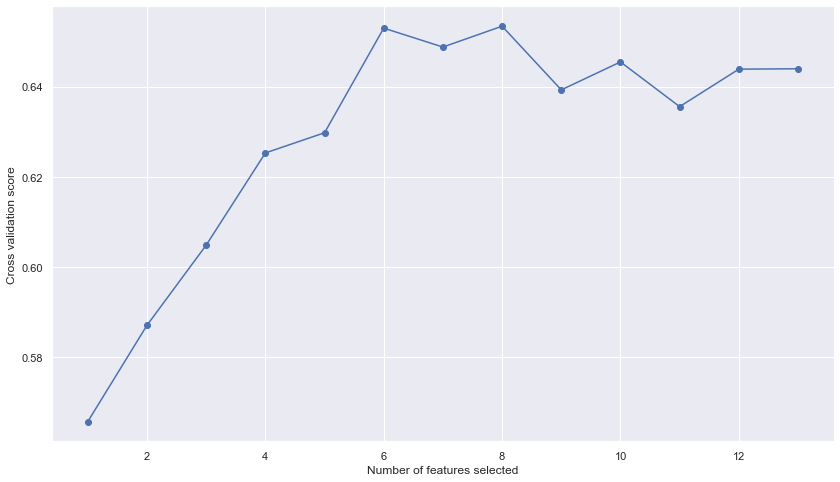

In [27]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")

mean_scores = grid_search.cv_results_['mean_test_score']
n_feat_to_select = range(min_features_to_select, mean_scores.shape[0] + 1)

plt.plot(n_feat_to_select, mean_scores, marker='o')
plt.show()

So far, this is the maximum score we have reached (6 predictors).